In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_device(device_no: int):
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{device_no}")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(device_no))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")

    return device


def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [4]:
device = set_device(0)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [5]:
class ExpMLP(torch.nn.Module):
    def __init__(self):
        super(ExpMLP, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 128, bias=False)  
        self.fc2 = torch.nn.Linear(128, 64, bias=False)      
        self.head = torch.nn.Linear(64, 10, bias=False)       
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)   
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x))
        x = self.head(x)           
        return x

In [6]:
def full_loop_with_norms(model, train_loader, test_loader, device, num_epochs=10, lr=1e-3, norm_order=2):
    train_losses, grad_norms, hess_hutch_norm_diffs, accuracy_arr= [], [], [], []
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward(retain_graph=True)
            train_losses.append(loss.item())

            grad = torch.autograd.grad(loss, model.head.parameters(), create_graph=True)[0]
            true_hess = torch.autograd.functional.hessian(lambda p: loss, tuple(model.head.parameters()))[0]
            u = torch.randn_like(grad)
            grad_dot_u = torch.sum(grad * u)
            hessian_vector_product = torch.autograd.grad(grad_dot_u, model.head.parameters(), retain_graph=True)[0]
            hutchinson = u * hessian_vector_product
            broadcast_shape = sum(p.numel() for p in model.head.parameters())
            hess_hutch_diff = true_hess[0].reshape(broadcast_shape, broadcast_shape) - torch.diag(hutchinson.flatten())
            hess_hutch_norm_diff = torch.norm(hess_hutch_diff, p=norm_order)
            grad_norm = torch.norm(grad, p=norm_order)
            grad_norms.append(grad_norm.item())
            hess_hutch_norm_diffs.append(hess_hutch_norm_diff.item())
            
            optimizer.step()

        print(f"Epoch {epoch}, Loss: {train_losses[-1]}")
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_arr.append(accuracy)
        print(f'Eval Accuracy: {accuracy:.2f}%')

    print("Training completed!")

    return train_losses, grad_norms, hess_hutch_norm_diffs, accuracy_arr

In [72]:
# after the test run i can determine the len of grad_norms and hess_hutch_norm_diffs
num_runs = 5
len_of_the_norms_arr = 9380
grad_norms_arr = np.zeros((num_runs, len_of_the_norms_arr))
hess_hutch_norm_diffs_arr = np.zeros((num_runs, len_of_the_norms_arr))

In [73]:
for run in range(num_runs):
    model = ExpMLP().to(device)
    _, grad_norms, hess_hutch_norm_diffs, _ = full_loop_with_norms(model, train_loader, test_loader, device, num_epochs=10, lr=1e-3, norm_order=2)
    grad_norms_arr[run] = grad_norms
    hess_hutch_norm_diffs_arr[run] = hess_hutch_norm_diffs

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Loss: 0.16471831500530243


 10%|█         | 1/10 [00:27<04:06, 27.35s/it]

Eval Accuracy: 93.34%
Epoch 1, Loss: 0.08128199726343155


 20%|██        | 2/10 [00:55<03:40, 27.54s/it]

Eval Accuracy: 94.79%
Epoch 2, Loss: 0.18630196154117584


 30%|███       | 3/10 [01:21<03:08, 26.96s/it]

Eval Accuracy: 96.04%
Epoch 3, Loss: 0.1874336451292038


 40%|████      | 4/10 [01:48<02:43, 27.17s/it]

Eval Accuracy: 96.47%
Epoch 4, Loss: 0.1722780019044876


 50%|█████     | 5/10 [02:15<02:14, 26.94s/it]

Eval Accuracy: 96.89%
Epoch 5, Loss: 0.04363790899515152


 60%|██████    | 6/10 [02:42<01:47, 26.94s/it]

Eval Accuracy: 96.83%
Epoch 6, Loss: 0.04858850687742233


 70%|███████   | 7/10 [03:09<01:20, 26.97s/it]

Eval Accuracy: 97.27%
Epoch 7, Loss: 0.008231107145547867


 80%|████████  | 8/10 [03:36<00:53, 26.97s/it]

Eval Accuracy: 97.21%
Epoch 8, Loss: 0.01233486644923687


 90%|█████████ | 9/10 [04:03<00:26, 26.95s/it]

Eval Accuracy: 97.54%
Epoch 9, Loss: 0.004773374646902084


100%|██████████| 10/10 [04:29<00:00, 26.97s/it]


Eval Accuracy: 97.69%
Training completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Loss: 0.0876985415816307


 10%|█         | 1/10 [00:27<04:06, 27.34s/it]

Eval Accuracy: 93.47%
Epoch 1, Loss: 0.14693371951580048


 20%|██        | 2/10 [00:54<03:36, 27.11s/it]

Eval Accuracy: 94.59%
Epoch 2, Loss: 0.2709306478500366


 30%|███       | 3/10 [01:21<03:09, 27.03s/it]

Eval Accuracy: 96.02%
Epoch 3, Loss: 0.16906940937042236


 40%|████      | 4/10 [01:47<02:40, 26.80s/it]

Eval Accuracy: 96.89%
Epoch 4, Loss: 0.02583748660981655


 50%|█████     | 5/10 [02:15<02:14, 27.00s/it]

Eval Accuracy: 96.96%
Epoch 5, Loss: 0.02854236401617527


 60%|██████    | 6/10 [02:41<01:47, 26.88s/it]

Eval Accuracy: 96.68%
Epoch 6, Loss: 0.07530542463064194


 70%|███████   | 7/10 [03:09<01:21, 27.06s/it]

Eval Accuracy: 97.29%
Epoch 7, Loss: 0.13233253359794617


 80%|████████  | 8/10 [03:35<00:53, 26.77s/it]

Eval Accuracy: 97.38%
Epoch 8, Loss: 0.1098342314362526


 90%|█████████ | 9/10 [04:02<00:26, 26.82s/it]

Eval Accuracy: 96.93%
Epoch 9, Loss: 0.004816711880266666


100%|██████████| 10/10 [04:28<00:00, 26.88s/it]


Eval Accuracy: 97.68%
Training completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Loss: 0.3124900758266449


 10%|█         | 1/10 [00:26<04:01, 26.79s/it]

Eval Accuracy: 93.17%
Epoch 1, Loss: 0.171805277466774


 20%|██        | 2/10 [00:53<03:33, 26.67s/it]

Eval Accuracy: 95.16%
Epoch 2, Loss: 0.08727450668811798


 30%|███       | 3/10 [01:20<03:08, 26.90s/it]

Eval Accuracy: 95.68%
Epoch 3, Loss: 0.01992025040090084


 40%|████      | 4/10 [01:47<02:40, 26.82s/it]

Eval Accuracy: 95.70%
Epoch 4, Loss: 0.2255481779575348


 50%|█████     | 5/10 [02:13<02:13, 26.64s/it]

Eval Accuracy: 96.82%
Epoch 5, Loss: 0.06674404442310333


 60%|██████    | 6/10 [02:39<01:46, 26.51s/it]

Eval Accuracy: 97.31%
Epoch 6, Loss: 0.00713349087163806


 70%|███████   | 7/10 [03:07<01:20, 26.86s/it]

Eval Accuracy: 97.02%
Epoch 7, Loss: 0.007812210358679295


 80%|████████  | 8/10 [03:33<00:53, 26.69s/it]

Eval Accuracy: 96.89%
Epoch 8, Loss: 0.06427161395549774


 90%|█████████ | 9/10 [04:01<00:27, 27.00s/it]

Eval Accuracy: 97.36%
Epoch 9, Loss: 0.061444345861673355


100%|██████████| 10/10 [04:27<00:00, 26.75s/it]


Eval Accuracy: 97.29%
Training completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Loss: 0.285597026348114


 10%|█         | 1/10 [00:27<04:11, 27.92s/it]

Eval Accuracy: 93.79%
Epoch 1, Loss: 0.3258337676525116


 20%|██        | 2/10 [00:54<03:36, 27.05s/it]

Eval Accuracy: 95.36%
Epoch 2, Loss: 0.0956311821937561


 30%|███       | 3/10 [01:21<03:09, 27.03s/it]

Eval Accuracy: 96.14%
Epoch 3, Loss: 0.02226410061120987


 40%|████      | 4/10 [01:48<02:41, 26.95s/it]

Eval Accuracy: 96.88%
Epoch 4, Loss: 0.035361018031835556


 50%|█████     | 5/10 [02:14<02:14, 26.85s/it]

Eval Accuracy: 97.10%
Epoch 5, Loss: 0.10142391920089722


 60%|██████    | 6/10 [02:41<01:47, 26.75s/it]

Eval Accuracy: 96.63%
Epoch 6, Loss: 0.01914195530116558


 70%|███████   | 7/10 [03:08<01:20, 26.93s/it]

Eval Accuracy: 97.16%
Epoch 7, Loss: 0.16950590908527374


 80%|████████  | 8/10 [03:35<00:53, 26.96s/it]

Eval Accuracy: 97.25%
Epoch 8, Loss: 0.020020052790641785


 90%|█████████ | 9/10 [04:02<00:26, 26.89s/it]

Eval Accuracy: 97.18%
Epoch 9, Loss: 0.0017014944460242987


100%|██████████| 10/10 [04:30<00:00, 27.04s/it]


Eval Accuracy: 97.48%
Training completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Loss: 0.29536664485931396


 10%|█         | 1/10 [00:26<03:57, 26.39s/it]

Eval Accuracy: 92.98%
Epoch 1, Loss: 0.20026010274887085


 20%|██        | 2/10 [00:53<03:35, 26.96s/it]

Eval Accuracy: 94.80%
Epoch 2, Loss: 0.3246176242828369


 30%|███       | 3/10 [01:20<03:07, 26.85s/it]

Eval Accuracy: 95.64%
Epoch 3, Loss: 0.04099380597472191


 40%|████      | 4/10 [01:47<02:42, 27.01s/it]

Eval Accuracy: 95.77%
Epoch 4, Loss: 0.38018104434013367


 50%|█████     | 5/10 [02:14<02:14, 26.89s/it]

Eval Accuracy: 96.66%
Epoch 5, Loss: 0.04878669232130051


 60%|██████    | 6/10 [02:41<01:48, 27.05s/it]

Eval Accuracy: 97.00%
Epoch 6, Loss: 0.009114261716604233


 70%|███████   | 7/10 [03:10<01:22, 27.57s/it]

Eval Accuracy: 96.94%
Epoch 7, Loss: 0.07721647620201111


 80%|████████  | 8/10 [03:36<00:54, 27.01s/it]

Eval Accuracy: 97.32%
Epoch 8, Loss: 0.05409408360719681


 90%|█████████ | 9/10 [04:01<00:26, 26.58s/it]

Eval Accuracy: 97.29%
Epoch 9, Loss: 0.0018587838858366013


100%|██████████| 10/10 [04:27<00:00, 26.79s/it]

Eval Accuracy: 97.02%
Training completed!


In [74]:
np.save('grad_norms_arr_demo.npy', grad_norms_arr)
np.save('hess_hutch_norm_diffs_arr_demo.npy', hess_hutch_norm_diffs_arr)

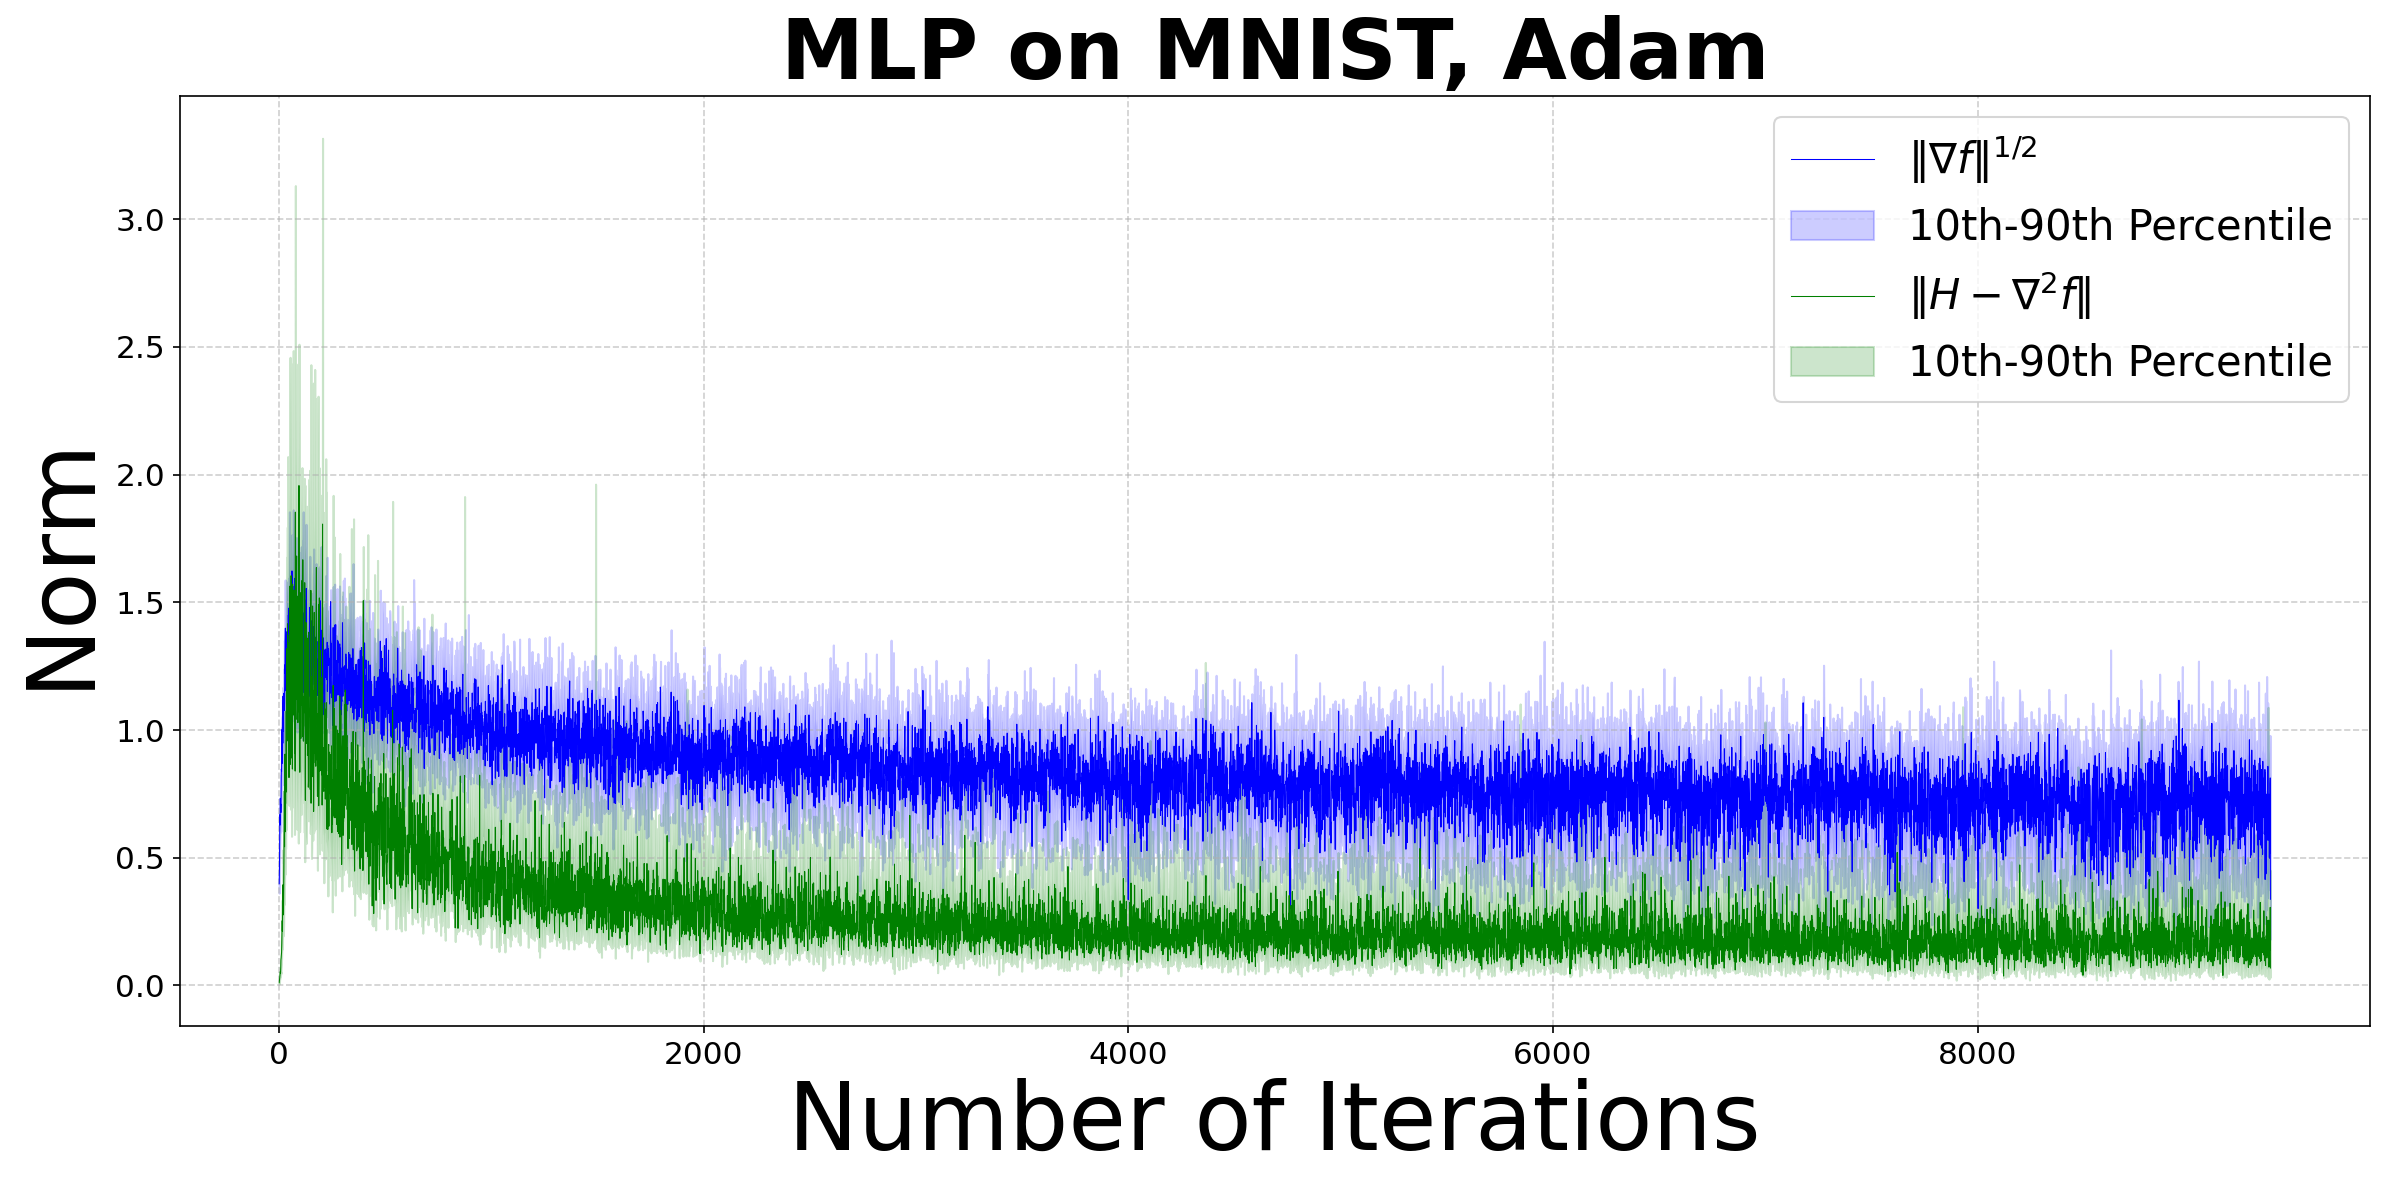

In [104]:
M_constant = 1  / 50

loaded_grad_norms_arr = np.load('grad_norms_arr_demo.npy')
loaded_hess_hutch_norm_diffs_arr = np.load('hess_hutch_norm_diffs_arr_demo.npy')

plot_grad_norms_arr = np.sqrt(loaded_grad_norms_arr)
plot_hess_hutch_norm_diffs_arr = M_constant * loaded_hess_hutch_norm_diffs_arr

gradp10 = np.percentile(plot_grad_norms_arr, 10, axis=0)
gradp50 = np.percentile(plot_grad_norms_arr, 50, axis=0)
gradp90 = np.percentile(plot_grad_norms_arr, 90, axis=0)

hessp10 = np.percentile(plot_hess_hutch_norm_diffs_arr, 10, axis=0)
hessp50 = np.percentile(plot_hess_hutch_norm_diffs_arr, 50, axis=0)
hessp90 = np.percentile(plot_hess_hutch_norm_diffs_arr, 90, axis=0)


plt.figure(figsize=(16, 8) ,dpi=150)

plt.plot(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
plt.fill_between(range(len(loaded_grad_norms_arr[0])), gradp10, gradp90, color='b', alpha=0.2, label='10th-90th Percentile')

plt.plot(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)
plt.fill_between(range(len(loaded_grad_norms_arr[0])), hessp10, hessp90, color='g', alpha=0.2, label='10th-90th Percentile')

plt.title('MLP on MNIST, Adam', fontsize=40, fontweight='bold')
plt.xlabel('Number of Iterations', fontsize=45)
plt.ylabel('Norm', fontsize=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()